# PB Portfolio Toolkit
### HSBC Private Bank Case Challenge 2026

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import minimize

## Section 1: Function Reference

### Data Preparation
- `estimate_params` — Daily returns → annualized expected returns (μ) and covariance matrix (Σ)

### Portfolio Optimization
- `mean_variance_optimize` — Optimal weights maximizing return for given risk, with client constraints (vol cap, group limits, min income)
- `black_litterman` — Market equilibrium + subjective views → adjusted returns and weights
- `risk_parity` — Equal risk contribution from each asset

### Analysis
- `scenario_analysis` — Portfolio return under Bull/Base/Bear scenarios
- `stress_test` — Portfolio drawdown during historical crises (2008, 2020, etc.)
- `backtest_portfolio` — Historical performance vs benchmark (return, Sharpe, MDD)
- `estimate_fee_structure` — Client total cost and bank revenue estimate

### Visualization
- `plot_efficient_frontier` — Risk vs return with recommended portfolio position
- `plot_allocation_pie` — Asset allocation pie chart
- `plot_scenario_bar` — Scenario comparison bar chart
- `plot_wealth_projection` — Monte Carlo wealth growth with confidence bands
- `plot_fee_impact` — Gross vs net return after fees
- `plot_risk_dashboard` — 4-panel dashboard (cumulative return, annual return, risk contribution, key metrics)

In [ ]:
COLORS = {
    "primary": "#DB0011",
    "dark": "#333333",
    "blue": "#1A73E8",
    "green": "#0A8043",
    "orange": "#E8710A",
    "purple": "#7B1FA2",
    "teal": "#00897B",
    "gray": "#9E9E9E",
    "light_gray": "#F5F5F5",
}
PALETTE = ["#DB0011", "#1A73E8", "#0A8043", "#E8710A", "#7B1FA2", "#00897B",
           "#F57C00", "#5C6BC0", "#00ACC1", "#8D6E63"]

def _setup_style():
    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.grid": True,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "grid.alpha": 0.3,
        "grid.linestyle": "--",
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.titleweight": "bold",
    })

def _format_pct(ax, axis="y"):
    fmt = mticker.FuncFormatter(lambda x, _: f"{x:.0%}")
    if axis == "y":
        ax.yaxis.set_major_formatter(fmt)
    else:
        ax.xaxis.set_major_formatter(fmt)

def _format_currency(ax, axis="y"):
    fmt = mticker.FuncFormatter(lambda x, _: f"${x:,.0f}")
    if axis == "y":
        ax.yaxis.set_major_formatter(fmt)

In [ ]:
def estimate_params(returns, method="historical", annualize=True, trading_days=252):
    asset_names = list(returns.columns)

    if method == "historical":
        mu = returns.mean().values
        cov = returns.cov().values
    elif method == "ewma":
        mu = returns.ewm(halflife=63).mean().iloc[-1].values
        cov = returns.ewm(halflife=63).cov().iloc[-len(asset_names):].values
    else:
        raise ValueError(f"Unknown method: {method}")

    if annualize:
        mu = mu * trading_days
        cov = cov * trading_days

    mu = mu.astype(np.float64)
    cov = cov.astype(np.float64)

    return mu, cov, asset_names

In [ ]:
def mean_variance_optimize(mu, cov, target_return=None, risk_aversion=None,
                           bounds=(0.0, 1.0), max_weight=None,
                           max_volatility=None, group_constraints=None,
                           min_income=None, income_yields=None):
    """
    Mean-Variance Optimization with client constraints.

    Modes (pick one):
        target_return  : find minimum variance portfolio achieving this return
        risk_aversion  : maximize utility = w'mu - (lambda/2)*w'Sigma*w
        neither        : maximize Sharpe ratio

    Constraints:
        bounds            : (min, max) per asset weight. default (0,1) = long only
        max_weight        : max weight for any single asset (e.g. 0.35 = 35%)
        max_volatility    : portfolio volatility upper bound (e.g. 0.10 = 10%)
        group_constraints : list of dicts, each with:
                            'assets'  : list of int indices
                            'min_pct' : minimum total weight for group
                            'max_pct' : maximum total weight for group
                            e.g. [{'assets': [0,1], 'max_pct': 0.40}]  # equity <= 40%
        min_income        : minimum portfolio income yield (e.g. 0.03 = 3%)
        income_yields     : np.ndarray of dividend/coupon yields per asset (required if min_income set)

    Returns:
        dict: weights, expected_return, volatility, sharpe
    """
    n = len(mu)
    asset_bounds = [(bounds[0], max_weight or bounds[1]) for _ in range(n)]
    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]

    # Volatility constraint
    if max_volatility is not None:
        constraints.append({
            "type": "ineq",
            "fun": lambda w: max_volatility**2 - w @ cov @ w
        })

    # Group constraints (e.g. equity <= 40%, bonds >= 30%)
    if group_constraints is not None:
        for gc in group_constraints:
            indices = gc["assets"]
            if "max_pct" in gc:
                cap = gc["max_pct"]
                constraints.append({
                    "type": "ineq",
                    "fun": lambda w, idx=indices, c=cap: c - sum(w[i] for i in idx)
                })
            if "min_pct" in gc:
                floor = gc["min_pct"]
                constraints.append({
                    "type": "ineq",
                    "fun": lambda w, idx=indices, f=floor: sum(w[i] for i in idx) - f
                })

    # Minimum income constraint
    if min_income is not None and income_yields is not None:
        constraints.append({
            "type": "ineq",
            "fun": lambda w: w @ income_yields - min_income
        })

    # Objective
    if target_return is not None:
        constraints.append({"type": "eq", "fun": lambda w: w @ mu - target_return})
        objective = lambda w: w @ cov @ w
    elif risk_aversion is not None:
        objective = lambda w: -(w @ mu - (risk_aversion / 2) * w @ cov @ w)
    else:
        objective = lambda w: -(w @ mu) / np.sqrt(w @ cov @ w)

    w0 = np.ones(n) / n
    result = minimize(objective, w0, method="SLSQP", bounds=asset_bounds,
                      constraints=constraints, options={"maxiter": 1000, "ftol": 1e-12})
    w = result.x
    ret = w @ mu
    vol = np.sqrt(w @ cov @ w)

    return {"weights": w, "expected_return": ret, "volatility": vol,
            "sharpe": ret / vol if vol > 0 else 0}

In [ ]:
def black_litterman(market_caps, cov, views, tau=0.05, risk_aversion=2.5, confidence=0.5):
    """
    Black-Litterman model: combine market equilibrium with subjective views.

    Parameters:
        market_caps : np.ndarray — relative market caps per asset
        cov         : np.ndarray — annualized covariance matrix
        views       : dict with:
                      'P' : list of lists — view matrix (k x n)
                      'Q' : list — view returns (k,)
                      e.g. asset 0 outperforms asset 1 by 2%:
                           P=[[1,-1,0,...]], Q=[0.02]
        tau         : float — uncertainty scaling (0.01~0.1)
        risk_aversion : float — risk aversion coefficient
        confidence  : float or np.ndarray — view confidence (0~1)

    Returns:
        dict: adjusted_mu, weights, market_eq_mu, expected_return, volatility
    """
    n = len(market_caps)
    P = np.array(views["P"])
    Q = np.array(views["Q"])
    k = len(Q)

    market_weights = market_caps / market_caps.sum()
    pi = risk_aversion * cov @ market_weights

    if isinstance(confidence, (int, float)):
        confidence = np.full(k, confidence)
    omega_diag = (1 / confidence - 1) * np.diag(P @ (tau * cov) @ P.T)
    omega = np.diag(omega_diag)

    tau_cov = tau * cov
    inv_tau_cov = np.linalg.inv(tau_cov)
    inv_omega = np.linalg.inv(omega)

    adjusted_mu = np.linalg.inv(inv_tau_cov + P.T @ inv_omega @ P) @ (
        inv_tau_cov @ pi + P.T @ inv_omega @ Q)

    w = np.linalg.inv(risk_aversion * cov) @ adjusted_mu
    w = np.maximum(w, 0)
    w = w / w.sum()
    ret = w @ adjusted_mu
    vol = np.sqrt(w @ cov @ w)

    return {"adjusted_mu": adjusted_mu, "weights": w, "market_eq_mu": pi,
            "expected_return": ret, "volatility": vol}

In [ ]:
def risk_parity(cov):
    """
    Risk Parity: equal risk contribution from each asset.

    Parameters:
        cov : np.ndarray — annualized covariance matrix

    Returns:
        dict: weights, risk_contributions (% of total risk), volatility
    """
    n = cov.shape[0]

    def objective(w):
        port_vol = np.sqrt(w @ cov @ w)
        marginal_risk = cov @ w / port_vol
        risk_contrib = w * marginal_risk
        target = port_vol / n
        return np.sum((risk_contrib - target) ** 2)

    w0 = np.ones(n) / n
    bounds = [(0.01, 1.0) for _ in range(n)]
    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    result = minimize(objective, w0, method="SLSQP", bounds=bounds,
                      constraints=constraints, options={"maxiter": 1000, "ftol": 1e-12})

    w = result.x
    port_vol = np.sqrt(w @ cov @ w)
    marginal_risk = cov @ w / port_vol
    risk_contrib = w * marginal_risk

    return {"weights": w, "risk_contributions": risk_contrib / risk_contrib.sum(),
            "volatility": port_vol}

In [ ]:
def scenario_analysis(weights, scenarios, aum=None):
    """
    Portfolio performance under different scenarios.

    Parameters:
        weights   : np.ndarray — asset weights
        scenarios : dict — {scenario_name: np.ndarray of annual returns per asset}
                    e.g. {'Bear': np.array([-0.15, 0.03, ...]), 'Base': ..., 'Bull': ...}
        aum       : float or None — initial investment amount

    Returns:
        pd.DataFrame — scenario, portfolio_return, [pnl, ending_value if aum given]
    """
    results = []
    for name, asset_returns in scenarios.items():
        port_ret = weights @ asset_returns
        row = {"scenario": name, "portfolio_return": port_ret}
        if aum is not None:
            row["pnl"] = aum * port_ret
            row["ending_value"] = aum * (1 + port_ret)
        results.append(row)
    return pd.DataFrame(results)

In [ ]:
DEFAULT_CRISIS_PERIODS = {
    "2008 Global Financial Crisis": ("2008-09-01", "2009-03-09"),
    "2020 COVID Crash": ("2020-02-19", "2020-03-23"),
    "2022 Rate Hike Selloff": ("2022-01-03", "2022-10-12"),
    "2018 Q4 Selloff": ("2018-10-01", "2018-12-24"),
    "2015 China Devaluation": ("2015-08-10", "2015-08-25"),
}

def stress_test(weights, returns, crisis_periods=None, aum=None):
    """
    Historical stress test across crisis periods.

    Parameters:
        weights        : np.ndarray — asset weights
        returns        : pd.DataFrame — daily returns
        crisis_periods : dict or None — {name: (start_date, end_date)}
                         uses DEFAULT_CRISIS_PERIODS if None
        aum            : float or None — initial investment amount

    Returns:
        pd.DataFrame — crisis, start, end, total_return, max_drawdown, max_daily_loss, trading_days
    """
    if crisis_periods is None:
        crisis_periods = DEFAULT_CRISIS_PERIODS

    results = []
    for name, (start, end) in crisis_periods.items():
        try:
            period_returns = returns.loc[start:end]
        except Exception:
            continue
        if period_returns.empty:
            continue

        port_returns = period_returns @ weights
        cumulative = (1 + port_returns).cumprod()
        drawdown = (cumulative / cumulative.cummax() - 1).min()
        total_return = cumulative.iloc[-1] - 1

        row = {"crisis": name, "start": start, "end": end,
               "total_return": total_return, "max_drawdown": drawdown,
               "max_daily_loss": port_returns.min(), "trading_days": len(period_returns)}
        if aum is not None:
            row["loss_amount"] = aum * total_return
        results.append(row)
    return pd.DataFrame(results)

In [ ]:
def backtest_portfolio(weights, returns, aum=None, benchmark_weights=None):
    """
    Portfolio backtest with optional benchmark comparison.

    Parameters:
        weights           : np.ndarray — asset weights
        returns           : pd.DataFrame — daily returns
        aum               : float or None — initial investment (None = normalize to 1)
        benchmark_weights : np.ndarray or None — benchmark weights for comparison

    Returns:
        dict: cumulative (pd.Series), annual_return, volatility, sharpe, max_drawdown, calmar
              benchmark (dict with same keys, or None)
    """
    initial = aum if aum is not None else 1.0

    def _compute(port_returns):
        cumulative = initial * (1 + port_returns).cumprod()
        years = len(port_returns) / 252
        total_ret = cumulative.iloc[-1] / initial - 1
        annual_ret = (1 + total_ret) ** (1 / years) - 1 if years > 0 else 0
        annual_vol = port_returns.std() * np.sqrt(252)
        sharpe = annual_ret / annual_vol if annual_vol > 0 else 0
        rolling_max = cumulative.cummax()
        mdd = ((cumulative - rolling_max) / rolling_max).min()
        return {"cumulative": cumulative, "annual_return": annual_ret,
                "volatility": annual_vol, "sharpe": sharpe, "max_drawdown": mdd,
                "calmar": annual_ret / abs(mdd) if mdd != 0 else 0}

    stats = _compute(returns @ weights)
    if benchmark_weights is not None:
        stats["benchmark"] = _compute(returns @ benchmark_weights)
    else:
        stats["benchmark"] = None
    return stats

In [ ]:
def estimate_fee_structure(weights, asset_names, aum, advisory_fee=0.01,
                          product_fees=None, years=5):
    """
    Fee structure analysis: client cost + bank revenue estimate.

    Parameters:
        weights      : np.ndarray — asset weights
        asset_names  : list[str]
        aum          : float — assets under management
        advisory_fee : float — annual advisory fee rate (e.g. 0.01 = 1%)
        product_fees : dict or None — {asset_name: embedded fee rate}
                       e.g. {'IG Bonds': 0.003, 'PE Fund': 0.015}
        years        : int — analysis period

    Returns:
        dict: annual_advisory_fee, annual_product_fees, total_annual_cost,
              total_annual_cost_pct, cumulative_cost, bank_annual_revenue, fee_breakdown (DataFrame)
    """
    if product_fees is None:
        product_fees = {}

    breakdown = []
    total_product_fee = 0.0
    for name, w in zip(asset_names, weights):
        pf = product_fees.get(name, 0.0)
        fee_amount = aum * w * pf
        total_product_fee += fee_amount
        breakdown.append({"asset": name, "weight": w, "allocated_aum": aum * w,
                          "product_fee_rate": pf, "product_fee_amount": fee_amount})

    annual_advisory = aum * advisory_fee
    total_annual = annual_advisory + total_product_fee

    return {
        "annual_advisory_fee": annual_advisory,
        "annual_product_fees": total_product_fee,
        "total_annual_cost": total_annual,
        "total_annual_cost_pct": total_annual / aum,
        "cumulative_cost": total_annual * years,
        "bank_annual_revenue": annual_advisory + total_product_fee * 0.5,
        "fee_breakdown": pd.DataFrame(breakdown),
    }

### Visualization Functions

In [ ]:
def plot_efficient_frontier(mu, cov, recommended=None, benchmarks=None, n_points=100):
    """
    Efficient frontier with recommended portfolio and benchmark positions.

    Parameters:
        mu, cov       : expected returns vector, covariance matrix
        recommended   : dict with 'expected_return', 'volatility', 'label' (or None)
        benchmarks    : dict of {name: {'expected_return': ..., 'volatility': ...}} (or None)
        n_points      : number of points on the frontier
    """
    _setup_style()

    min_ret, max_ret = mu.min() * 0.5, mu.max() * 1.2
    target_returns = np.linspace(min_ret, max_ret, n_points)

    frontier_vols, frontier_rets = [], []
    for tr in target_returns:
        try:
            res = mean_variance_optimize(mu, cov, target_return=tr)
            frontier_vols.append(res["volatility"])
            frontier_rets.append(res["expected_return"])
        except:
            continue

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(frontier_vols, frontier_rets, color=COLORS["dark"], linewidth=2, label="Efficient Frontier")

    if recommended:
        label = recommended.get("label", "Recommended")
        ax.scatter(recommended["volatility"], recommended["expected_return"],
                   color=COLORS["primary"], s=200, zorder=5, edgecolors="white", linewidth=2, label=label)
        ax.annotate(f'  {label}\n  Return: {recommended["expected_return"]:.1%}\n  Risk: {recommended["volatility"]:.1%}',
                    (recommended["volatility"], recommended["expected_return"]),
                    fontsize=9, fontweight="bold", color=COLORS["primary"])

    if benchmarks:
        for name, bm in benchmarks.items():
            ax.scatter(bm["volatility"], bm["expected_return"],
                       color=COLORS["gray"], s=120, marker="D", zorder=4, edgecolors="white")
            ax.annotate(f"  {name}", (bm["volatility"], bm["expected_return"]), fontsize=9, color=COLORS["gray"])

    ax.set_xlabel("Annual Volatility (Risk)")
    ax.set_ylabel("Expected Annual Return")
    ax.set_title("Portfolio Optimization - Risk vs Return")
    ax.legend(loc="upper left", frameon=True)
    _format_pct(ax, "x"); _format_pct(ax, "y")
    plt.tight_layout()
    return fig

In [ ]:
def plot_allocation_pie(weights, asset_names, title="Recommended Asset Allocation"):
    """
    Asset allocation pie chart. Filters out assets with weight < 0.5%.

    Parameters:
        weights     : np.ndarray
        asset_names : list[str]
        title       : str
    """
    _setup_style()
    mask = weights > 0.005
    w, names = weights[mask], [n for n, m in zip(asset_names, mask) if m]

    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(
        w, labels=names, autopct="%1.1f%%", colors=PALETTE[:len(w)],
        startangle=90, pctdistance=0.8, labeldistance=1.1,
        wedgeprops={"linewidth": 2, "edgecolor": "white"})
    for t in autotexts:
        t.set_fontsize(11); t.set_fontweight("bold"); t.set_color("white")
    ax.set_title(title, fontsize=14, fontweight="bold", pad=20)
    plt.tight_layout()
    return fig

In [ ]:
def plot_scenario_bar(scenario_df, aum=None):
    """
    Scenario comparison bar chart.

    Parameters:
        scenario_df : pd.DataFrame from scenario_analysis()
        aum         : float or None — if given, shows absolute PnL on labels
    """
    _setup_style()
    fig, ax = plt.subplots(figsize=(10, 6))

    scenarios, returns = scenario_df["scenario"], scenario_df["portfolio_return"]
    bar_colors = [COLORS["green"] if r > 0.05 else COLORS["blue"] if r >= 0 else COLORS["primary"] for r in returns]
    bars = ax.bar(scenarios, returns, color=bar_colors, width=0.5, edgecolor="white", linewidth=1.5)

    for bar, ret in zip(bars, returns):
        label = f"{ret:+.1%}"
        if aum: label += f"\n(${aum * ret:+,.0f})"
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), label,
                ha="center", va="bottom" if ret >= 0 else "top", fontweight="bold", fontsize=11)

    ax.axhline(y=0, color=COLORS["dark"], linewidth=0.8)
    ax.set_title("Portfolio Performance by Scenario")
    ax.set_ylabel("Expected Return")
    _format_pct(ax)
    plt.tight_layout()
    return fig

In [ ]:
def plot_wealth_projection(aum, expected_return, volatility, years=10,
                          n_simulations=1000, annual_fee=0.0):
    """
    Monte Carlo wealth projection with confidence bands.

    Parameters:
        aum             : float — initial investment
        expected_return : float — annual expected return
        volatility      : float — annual volatility
        years           : int — projection horizon
        n_simulations   : int — number of GBM paths
        annual_fee      : float — annual fee rate (deducted from return)
    """
    _setup_style()
    np.random.seed(42)

    net_return = expected_return - annual_fee
    dt = 1 / 252
    n_days = years * 252

    Z = np.random.standard_normal((n_simulations, n_days))
    log_returns = (net_return - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * Z
    paths = aum * np.exp(np.cumsum(log_returns, axis=1))
    paths = np.column_stack([np.full(n_simulations, aum), paths])
    time_axis = np.linspace(0, years, n_days + 1)

    median = np.median(paths, axis=0)
    p10, p25, p75, p90 = [np.percentile(paths, p, axis=0) for p in [10, 25, 75, 90]]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.fill_between(time_axis, p10, p90, alpha=0.1, color=COLORS["blue"], label="10th-90th pctl")
    ax.fill_between(time_axis, p25, p75, alpha=0.2, color=COLORS["blue"], label="25th-75th pctl")
    ax.plot(time_axis, median, color=COLORS["primary"], linewidth=2.5, label="Median")
    ax.axhline(y=aum, color=COLORS["gray"], linestyle="--", linewidth=1, label=f"Initial: ${aum:,.0f}")

    for pval, plabel in [(p90[-1], "90th"), (median[-1], "Median"), (p10[-1], "10th")]:
        ax.annotate(f"  ${pval:,.0f} ({plabel})", (years, pval), fontsize=9, fontweight="bold", va="center")

    ax.set_xlabel("Years"); ax.set_ylabel("Portfolio Value")
    ax.set_title(f"Wealth Projection - ${aum:,.0f} Initial Investment")
    ax.legend(loc="upper left", frameon=True)
    _format_currency(ax)
    plt.tight_layout()
    return fig

In [ ]:
def plot_fee_impact(aum, expected_return, total_fee_rate, years=10):
    """
    Fee impact: gross vs net asset growth comparison.

    Parameters:
        aum             : float — initial investment
        expected_return : float — annual gross return
        total_fee_rate  : float — annual total fee rate
        years           : int — projection horizon
    """
    _setup_style()
    t = np.arange(0, years + 1)
    gross = aum * (1 + expected_return) ** t
    net = aum * (1 + expected_return - total_fee_rate) ** t

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t, gross, color=COLORS["blue"], linewidth=2.5, marker="o", markersize=5,
            label=f"Before Fees ({expected_return:.1%})")
    ax.plot(t, net, color=COLORS["primary"], linewidth=2.5, marker="o", markersize=5,
            label=f"After Fees ({expected_return - total_fee_rate:.1%})")
    ax.fill_between(t, net, gross, alpha=0.1, color=COLORS["primary"])

    fee_cost = gross[-1] - net[-1]
    ax.annotate(f"Fee Impact over {years}yr:\n${fee_cost:,.0f}",
                xy=(years, (gross[-1]+net[-1])/2), xytext=(years-2.5, gross[-1]*0.85),
                fontsize=10, fontweight="bold", color=COLORS["primary"],
                arrowprops=dict(arrowstyle="->", color=COLORS["primary"]))

    ax.set_xlabel("Years"); ax.set_ylabel("Portfolio Value")
    ax.set_title(f"Fee Impact Analysis - ${aum:,.0f} Investment")
    ax.legend(loc="upper left", frameon=True)
    _format_currency(ax)
    plt.tight_layout()
    return fig

In [ ]:
def plot_risk_dashboard(weights, returns, asset_names, aum=None):
    """
    Risk dashboard (4 panels): cumulative return & drawdown, annual returns,
    risk contribution by asset, key risk metrics table.

    Parameters:
        weights     : np.ndarray — asset weights
        returns     : pd.DataFrame — daily returns
        asset_names : list[str]
        aum         : float or None — initial investment
    """
    _setup_style()

    port_returns = (returns @ weights).astype(np.float64)
    cumulative = (1 + port_returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Panel 1: Cumulative + Drawdown
    ax1 = axes[0, 0]
    ax1_dd = ax1.twinx()
    if aum:
        ax1.plot(cumulative.index, cumulative * aum, color=COLORS["blue"], linewidth=1.5)
        _format_currency(ax1)
    else:
        ax1.plot(cumulative.index, cumulative, color=COLORS["blue"], linewidth=1.5)
    ax1_dd.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color=COLORS["primary"])
    ax1_dd.set_ylabel("Drawdown", color=COLORS["primary"])
    _format_pct(ax1_dd)
    ax1.set_title("Cumulative Return & Drawdown")

    # Panel 2: Annual Returns
    ax2 = axes[0, 1]
    annual = port_returns.resample("YE").apply(lambda x: (1 + x).prod() - 1)
    bar_colors = [COLORS["green"] if r >= 0 else COLORS["primary"] for r in annual]
    ax2.bar(annual.index.year, annual.values, color=bar_colors, width=0.7)
    for yr, r in zip(annual.index.year, annual.values):
        ax2.text(yr, r, f"{r:+.1%}", ha="center", va="bottom" if r >= 0 else "top",
                 fontsize=9, fontweight="bold")
    ax2.axhline(y=0, color=COLORS["dark"], linewidth=0.8)
    ax2.set_title("Annual Returns")
    _format_pct(ax2)

    # Panel 3: Risk Contribution
    ax3 = axes[1, 0]
    cov_ann = returns.cov().values * 252
    port_vol = np.sqrt(weights @ cov_ann @ weights)
    marginal = cov_ann @ weights / port_vol
    risk_pct = (weights * marginal) / (weights * marginal).sum()
    mask = risk_pct > 0.005
    ax3.barh([n for n, m in zip(asset_names, mask) if m], risk_pct[mask],
             color=PALETTE[:mask.sum()], height=0.5)
    for i, v in enumerate(risk_pct[mask]):
        ax3.text(v + 0.01, i, f"{v:.1%}", va="center", fontweight="bold")
    ax3.set_title("Risk Contribution by Asset")
    _format_pct(ax3, "x")

    # Panel 4: Key Metrics Table
    ax4 = axes[1, 1]
    ax4.axis("off")
    annual_ret = port_returns.mean() * 252
    annual_vol = port_returns.std() * np.sqrt(252)
    sharpe = annual_ret / annual_vol if annual_vol > 0 else 0
    mdd = drawdown.min()
    var_95 = np.percentile(port_returns, 5)

    metrics = [("Annual Return", f"{annual_ret:.2%}"), ("Annual Volatility", f"{annual_vol:.2%}"),
               ("Sharpe Ratio", f"{sharpe:.2f}"), ("Max Drawdown", f"{mdd:.2%}"),
               ("Daily VaR (95%)", f"{var_95:.2%}")]
    if aum:
        metrics.insert(0, ("Initial Investment", f"${aum:,.0f}"))
        metrics.append(("Worst Case Loss (MDD)", f"${aum * mdd:,.0f}"))

    table = ax4.table(cellText=[[m[1]] for m in metrics], rowLabels=[m[0] for m in metrics],
                      colLabels=["Value"], cellLoc="center", rowLoc="right", loc="center")
    table.auto_set_font_size(False); table.set_fontsize(11); table.scale(1.2, 1.8)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_facecolor(COLORS["primary"]); cell.set_text_props(color="white", fontweight="bold")
        elif row % 2 == 0:
            cell.set_facecolor(COLORS["light_gray"])
        cell.set_edgecolor("white")
    ax4.set_title("Key Risk Metrics", fontsize=14, fontweight="bold")

    fig.suptitle("Risk Dashboard", fontsize=16, fontweight="bold", y=1.01)
    plt.tight_layout()
    return fig

---
## Section 2: Data Preparation

In [17]:
import wrds

conn = wrds.Connection()

# ── Define tickers and asset names ──
# Modify these when the case is released

TICKER_MAP = {
    "SPY": "Global Equity",
    "EEM": "EM Equity",
    "AGG": "IG Bonds",
    "HYG": "HY Bonds",
    "GLD": "Gold",
    "VNQ": "REITs",
}

tickers = list(TICKER_MAP.keys())
start_date = "2014-01-01"
end_date = "2024-12-31"

# ── Fetch daily returns from CRSP ──

query = f"""
    SELECT a.date, b.ticker, a.ret
    FROM crsp.dsf AS a
    JOIN crsp.dsenames AS b
      ON a.permno = b.permno
     AND b.namedt <= a.date
     AND a.date <= b.nameendt
    WHERE b.ticker IN ({','.join(f"'{t}'" for t in tickers)})
      AND a.date BETWEEN '{start_date}' AND '{end_date}'
    ORDER BY a.date, b.ticker
"""

raw = conn.raw_sql(query)
returns = raw.pivot(index="date", columns="ticker", values="ret").dropna()
returns.columns = [TICKER_MAP[t] for t in returns.columns]

print(f"Data: {returns.shape[0]} days, {returns.shape[1]} assets")
print(f"Period: {returns.index[0]} ~ {returns.index[-1]}")
returns.head()

returns.index = pd.to_datetime(returns.index)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Data: 2768 days, 6 assets
Period: 2014-01-02 ~ 2024-12-31


✓ estimate_params
✓ mean_variance_optimize — Return: 9.09%, Vol: 10.28%
✓ black_litterman — Return: 1.35%
✓ risk_parity — Vol: 7.17%
✓ scenario_analysis
✓ stress_test — 4 crisis periods found
✓ backtest_portfolio — Sharpe: 0.87
✓ estimate_fee_structure — Total cost: 1.14%


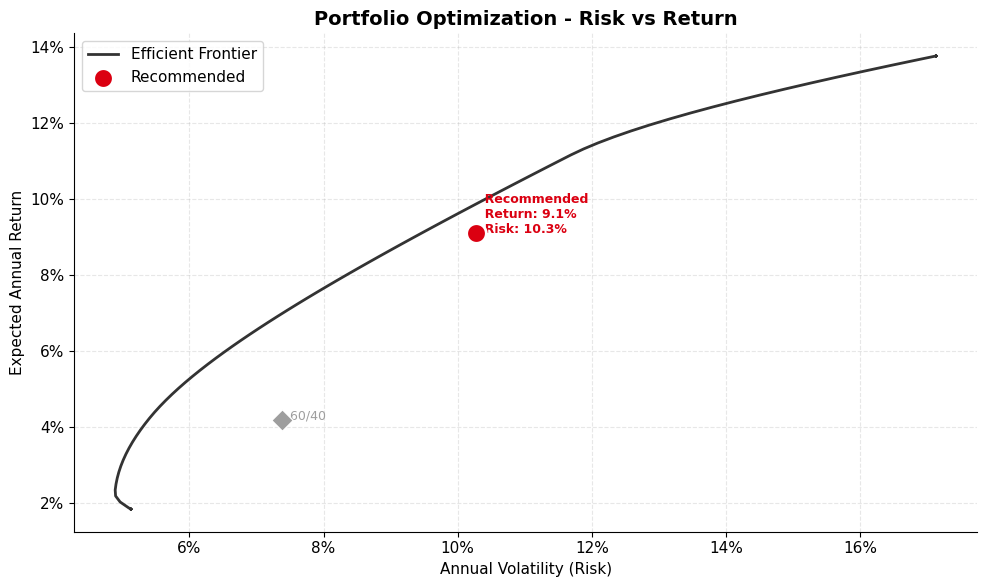

✓ plot_efficient_frontier


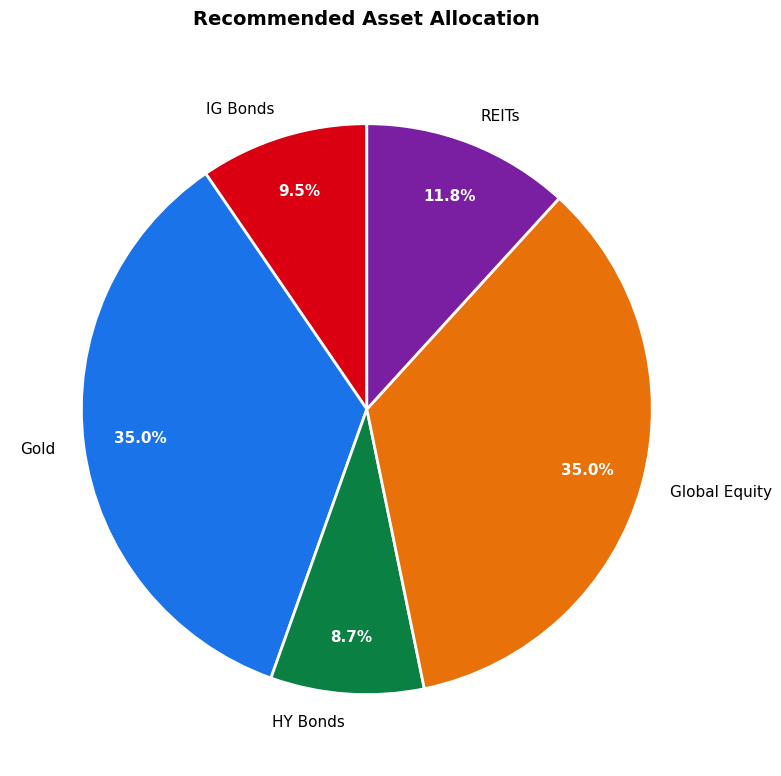

✓ plot_allocation_pie


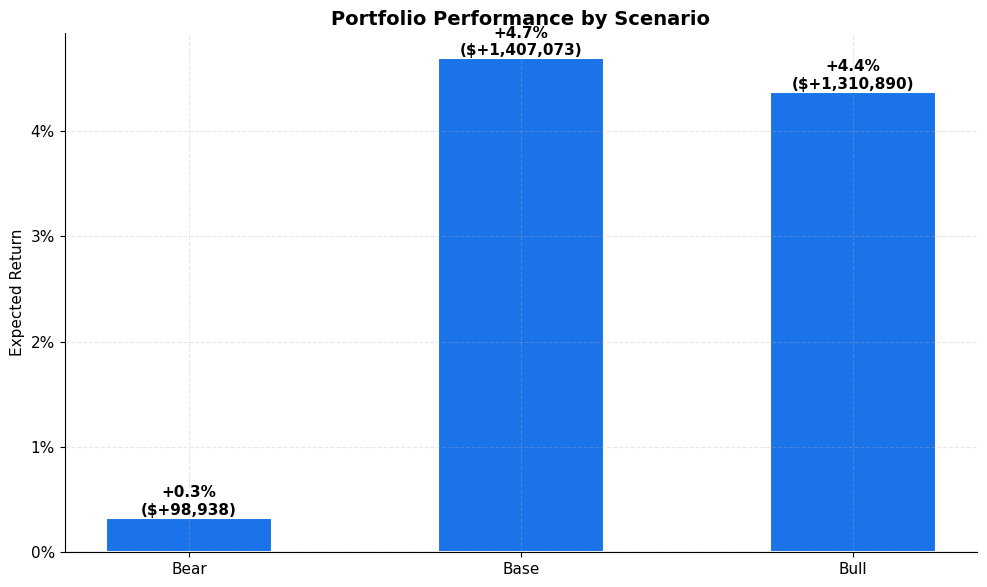

✓ plot_scenario_bar


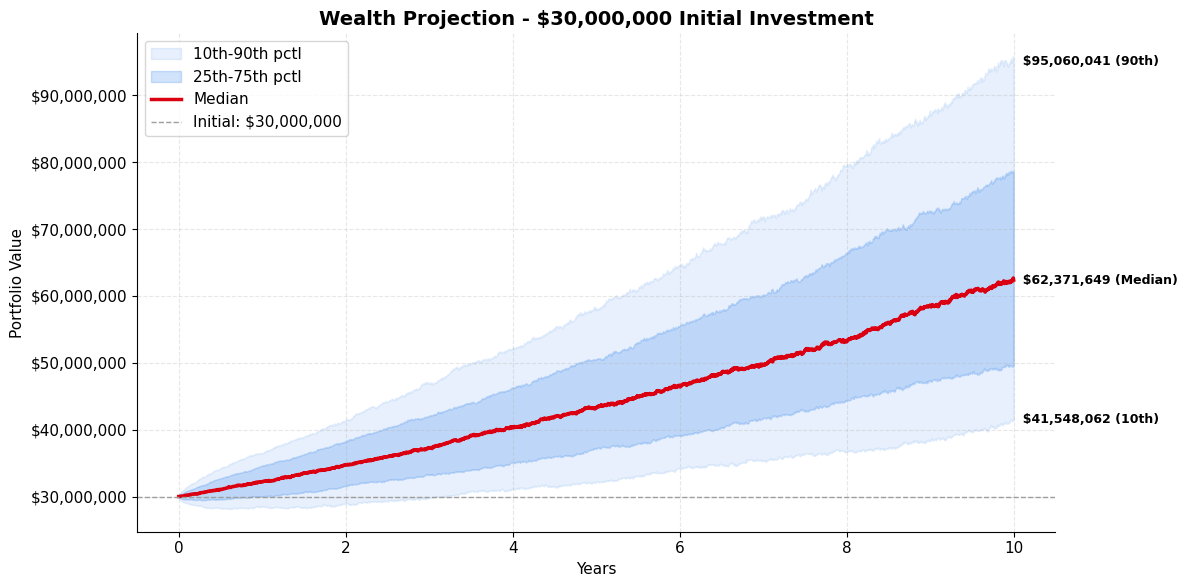

✓ plot_wealth_projection


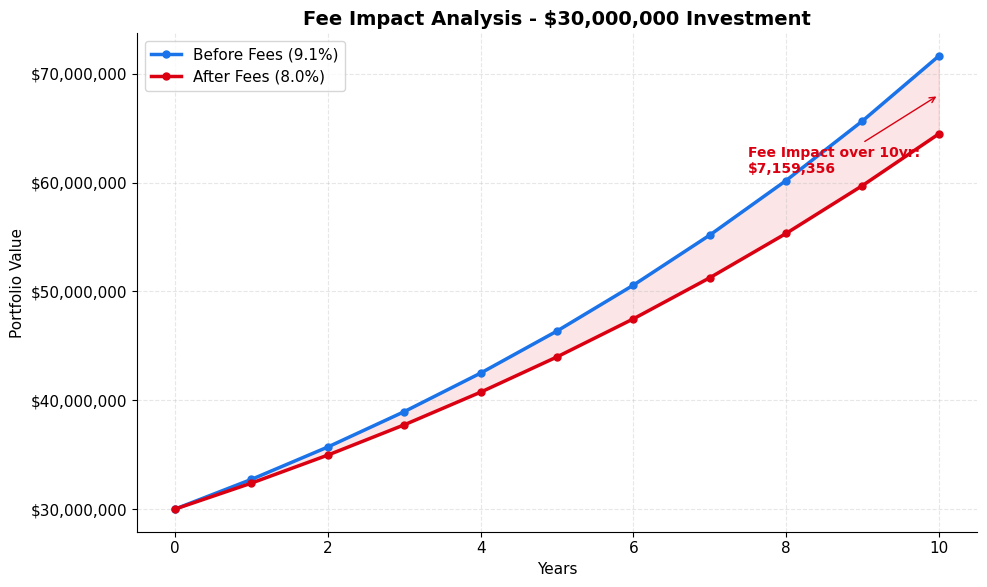

✓ plot_fee_impact


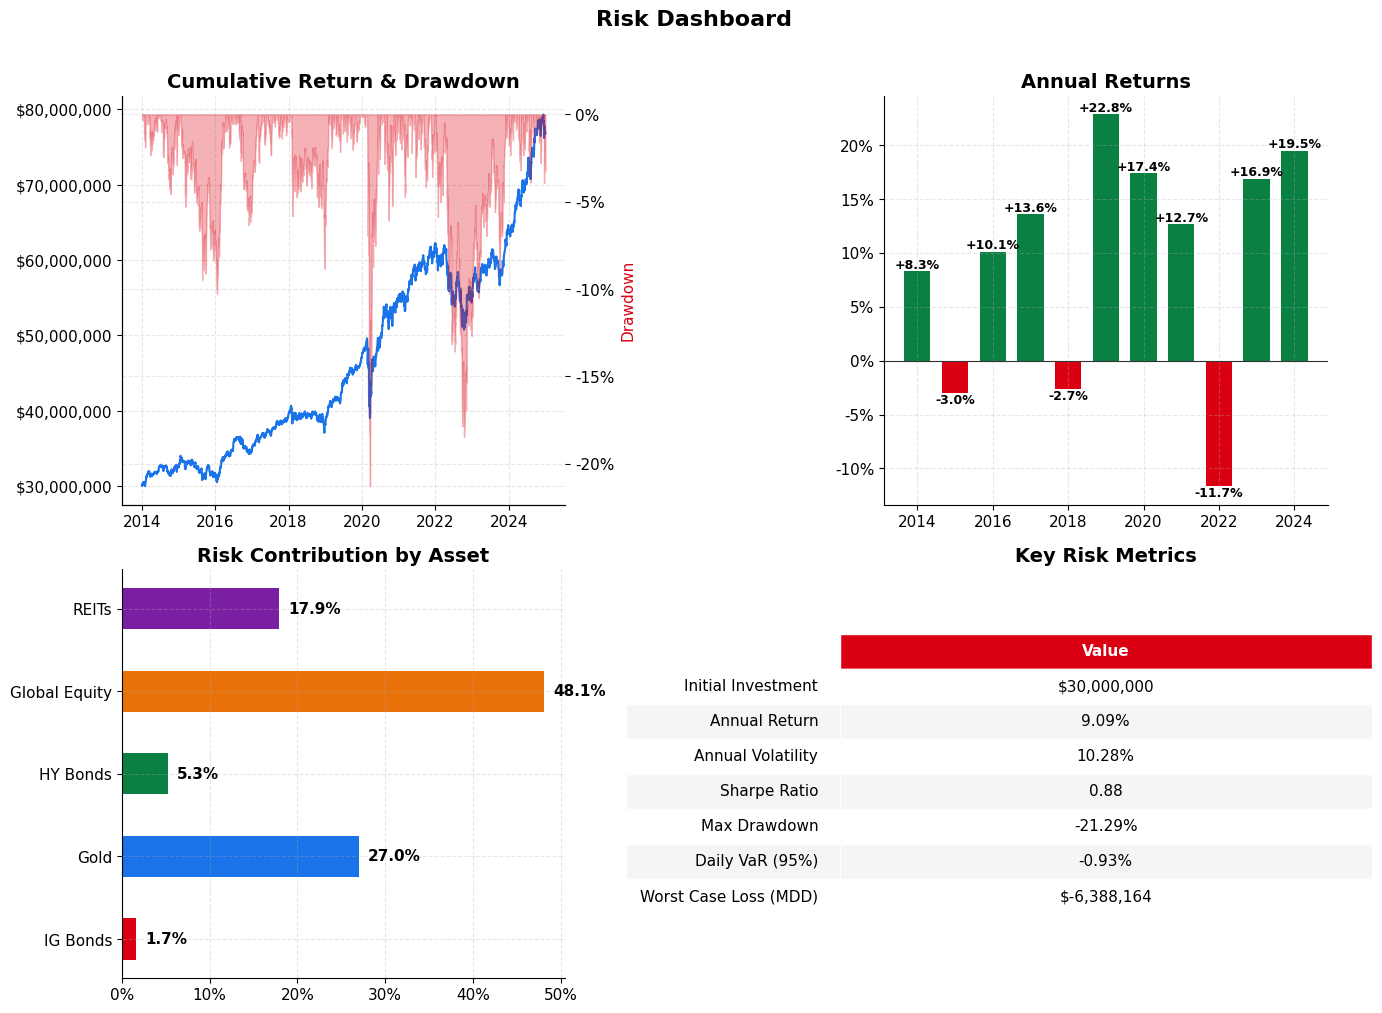

✓ plot_risk_dashboard

=== ALL TESTS PASSED ===


In [18]:
# 1. Estimate parameters
mu, cov, names = estimate_params(returns)
print("✓ estimate_params")

# 2. Mean-Variance Optimization
mvo = mean_variance_optimize(mu, cov, risk_aversion=5, max_weight=0.35)
print(f"✓ mean_variance_optimize — Return: {mvo['expected_return']:.2%}, Vol: {mvo['volatility']:.2%}")

# 3. Black-Litterman
market_caps = np.array([50, 15, 30, 10, 5, 8])
bl = black_litterman(market_caps, cov, views={"P": [[-1,1,0,0,0,0]], "Q": [0.02]}, confidence=0.6)
print(f"✓ black_litterman — Return: {bl['expected_return']:.2%}")

# 4. Risk Parity
rp = risk_parity(cov)
print(f"✓ risk_parity — Vol: {rp['volatility']:.2%}")

# 5. Scenario Analysis
sc = scenario_analysis(mvo["weights"], {
    "Bear": np.array([-0.15, -0.25, 0.03, -0.05, 0.10, -0.20]),
    "Base": np.array([0.08, 0.10, 0.035, 0.055, 0.04, 0.07]),
    "Bull": np.array([0.20, 0.25, 0.02, 0.08, -0.02, 0.15]),
}, aum=30_000_000)
print("✓ scenario_analysis")

# 6. Stress Test
st = stress_test(mvo["weights"], returns, aum=30_000_000)
print(f"✓ stress_test — {len(st)} crisis periods found")

# 7. Backtest
bt = backtest_portfolio(mvo["weights"], returns, aum=30_000_000,
                        benchmark_weights=np.array([0.6, 0.0, 0.4, 0.0, 0.0, 0.0]))
print(f"✓ backtest_portfolio — Sharpe: {bt['sharpe']:.2f}")

# 8. Fee Structure
fees = estimate_fee_structure(mvo["weights"], names, 30_000_000, advisory_fee=0.01,
                              product_fees={"IG Bonds": 0.003, "HY Bonds": 0.005, "REITs": 0.006})
print(f"✓ estimate_fee_structure — Total cost: {fees['total_annual_cost_pct']:.2%}")

# 9-14. Visualization
plot_efficient_frontier(mu, cov,
    recommended={"expected_return": mvo["expected_return"], "volatility": mvo["volatility"], "label": "Recommended"},
    benchmarks={"60/40": {"expected_return": np.array([0.6,0,0.4,0,0,0]) @ mu,
                          "volatility": np.sqrt(np.array([0.6,0,0.4,0,0,0]) @ cov @ np.array([0.6,0,0.4,0,0,0]))}})
plt.show()
print("✓ plot_efficient_frontier")

plot_allocation_pie(mvo["weights"], names)
plt.show()
print("✓ plot_allocation_pie")

plot_scenario_bar(sc, aum=30_000_000)
plt.show()
print("✓ plot_scenario_bar")

plot_wealth_projection(30_000_000, mvo["expected_return"], mvo["volatility"], years=10, annual_fee=fees["total_annual_cost_pct"])
plt.show()
print("✓ plot_wealth_projection")

plot_fee_impact(30_000_000, mvo["expected_return"], fees["total_annual_cost_pct"], years=10)
plt.show()
print("✓ plot_fee_impact")

plot_risk_dashboard(mvo["weights"], returns, names, aum=30_000_000)
plt.show()
print("✓ plot_risk_dashboard")

print("\n=== ALL TESTS PASSED ===")